In [1]:
batch_size = 64
ncomps = 500
crop_size = 180

In [2]:

import os
import sys
import random
import numpy as np
import pandas as pd
import torch
from monai.data import DataLoader
from monai.transforms import Compose, NormalizeIntensity, ToTensor
import matplotlib.pyplot as plt
# import config_file as cfg
# from utils import get_model
# from torchsummary import summary

import torchvision.transforms.functional as F

/home/volatope/Software/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-05-22 15:31:17.469647: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 15:31:17.470758: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 15:31:17.495334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow w

In [3]:
from pathlib import Path

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')
exp_name = 'near_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/exp_name/'train'

test_csv_path = macaw_path/'splits'/'test.csv'
test_img_path = macaw_path/exp_name/'test'
# 
kpca_path = macaw_path/exp_name/f'train_hc_kpca_{ncomps}.pkl'
# 
train_path = macaw_path/exp_name/f'train_hc_data_KPCA_{ncomps}.pkl'
test_path = macaw_path/exp_name/f'test_hc_data_KPCA_{ncomps}.pkl'

In [4]:
home_dir = './'
working_dir = home_dir + exp_name + '/'

df_train = pd.read_csv(os.path.join(home_dir, "splits/train.csv"))
df_val = pd.read_csv(os.path.join(home_dir, "splits/val.csv"))

train_fpaths = [os.path.join(working_dir, "train", filename.replace(".nii.gz", ".tiff")) for filename in df_train['filename']]
train_class_label = df_train['class_label']

# val_fpaths = [os.path.join(working_dir, "val", filename.replace(".nii.gz", ".tiff")) for filename in df_val['filename']]
# val_class_label = df_val['class_label']

In [5]:
def recons(age,bmi,latents, latent_offset=0):
    age+=min_age
    
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    imgs = kpca.inverse_transform(latent_enc)
    return age,bmi,imgs

def show(data,n=4):
    fig, axs = plt.subplots(ncols=n, squeeze=False, figsize=(10,10))
    for i in range(n):
        img = F.to_pil_image(data[0][i].detach())
        axs[0, i].imshow(np.asarray(img), cmap='cividis')        
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=make_label(data,i))
        
def make_label(d,i):
    s = ['Female', 'Male']
    return f"Sex: {s[int(d[0][i])]},  Age: {np.round(d[1][i])},\n BMI: {np.round(d[2][i],2)}"

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [7]:
seed = 1  # You can use any integer as the seed
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [8]:
from utils.datasets import EmmaDataset
from monai.data import pad_list_data_collate
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB

# Define transforms
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])
# train_dataset = UKBBT1Dataset(train_csv_path, train_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))

# create a training data loader - include padding
# train_ds = ImageDataset(image_files=train_fpaths, labels=train_class_label, transform=transforms, reader="ITKReader")
train_ds = EmmaDataset(train_csv_path, train_img_path, transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

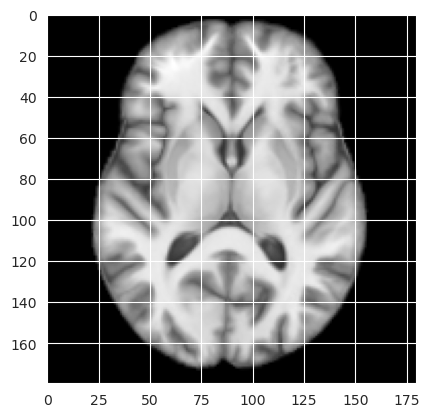

In [9]:
plt.imshow(next(iter(train_loader))[2][1], cmap='gray')

In [10]:
imgs = np.concatenate([d[2].numpy() for d in train_loader],axis=0)
imgs = imgs.reshape(imgs.shape[0],-1)
imgs_dim = imgs.shape[1]

In [11]:
imgs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=ncomps, kernel="poly", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3)
kpca.fit(imgs)

KernelPCA(alpha=0.005, fit_inverse_transform=True, gamma=0.001, kernel='poly',
          n_components=500)

In [13]:
kpca_path

PosixPath('/home/volatope/PycharmProjects/CounterBias/near_bias/train_hc_kpca_500.pkl')

## Dimensionality reduction

In [14]:
import pickle
from sklearn.decomposition import KernelPCA

# if os.path.exists(kpca_path):
#     with open(kpca_path, 'rb') as f:
#         kpca = pickle.load(f)
# else:
kpca = KernelPCA(n_components=ncomps, kernel="poly", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3)
kpca.fit(imgs)

with open(kpca_path, 'wb') as f:
    pickle.dump(kpca, f)

In [15]:
disease = np.concatenate([d[0].numpy() for d in train_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in train_loader],axis=0)

In [16]:
encoded_data = kpca.transform(imgs)

In [17]:
with open(train_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease':disease,'bias':bias, 'kpca':kpca,'encoded_data':encoded_data}, f)

In [18]:
test_ds = EmmaDataset(test_csv_path, test_img_path, transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

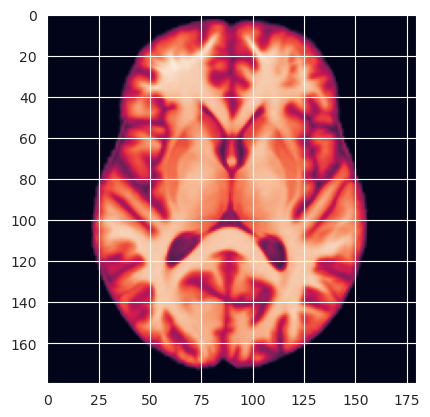

In [19]:
plt.imshow(next(iter(train_loader))[2][1])

In [20]:
test_imgs = np.concatenate([d[2].numpy() for d in test_loader],axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0],-1)
test_imgs_dim = test_imgs.shape[1]

In [21]:
sample_imgs = test_imgs[:5,:]
t = kpca.transform(sample_imgs)
X_recon = kpca.inverse_transform(t)

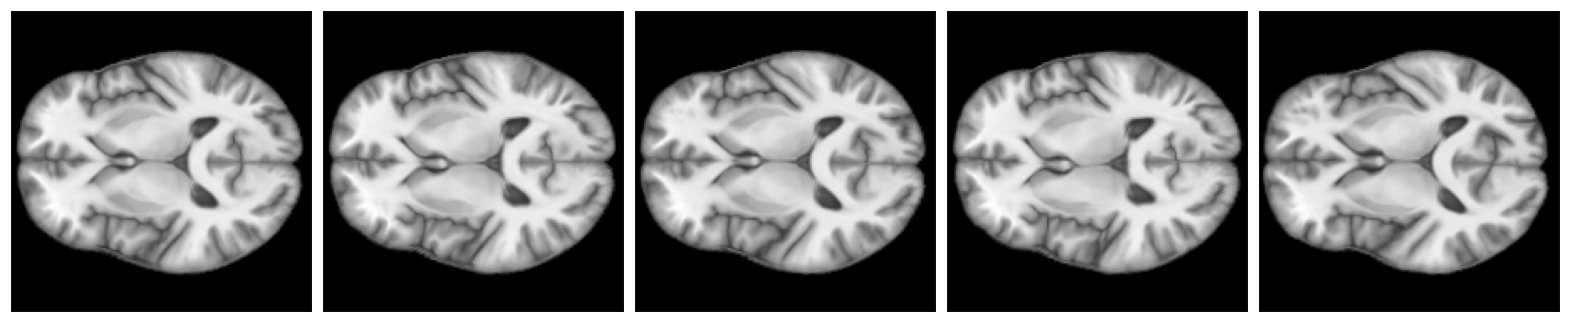

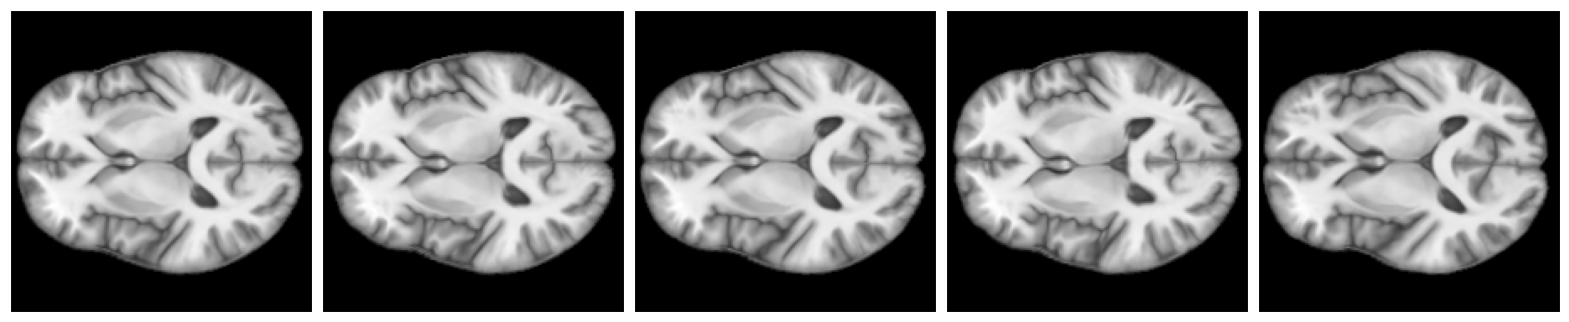

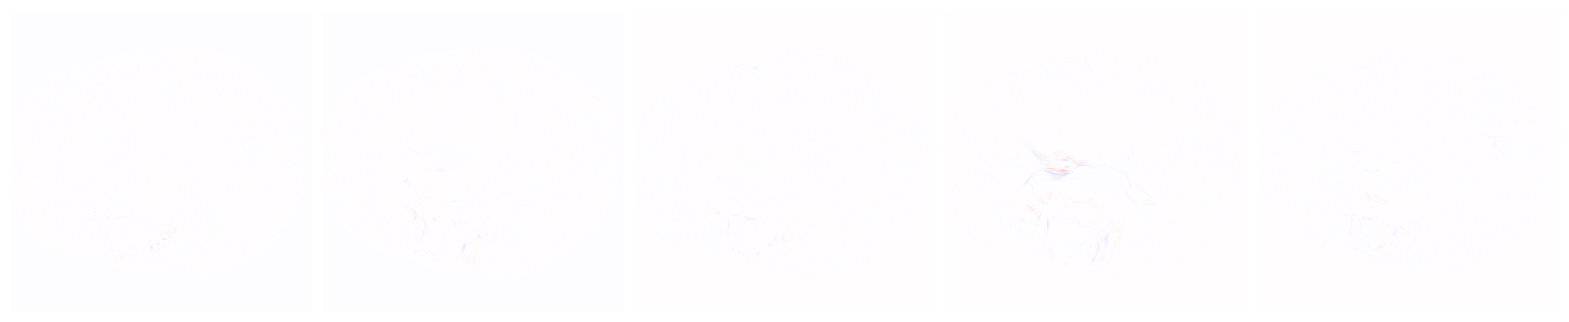

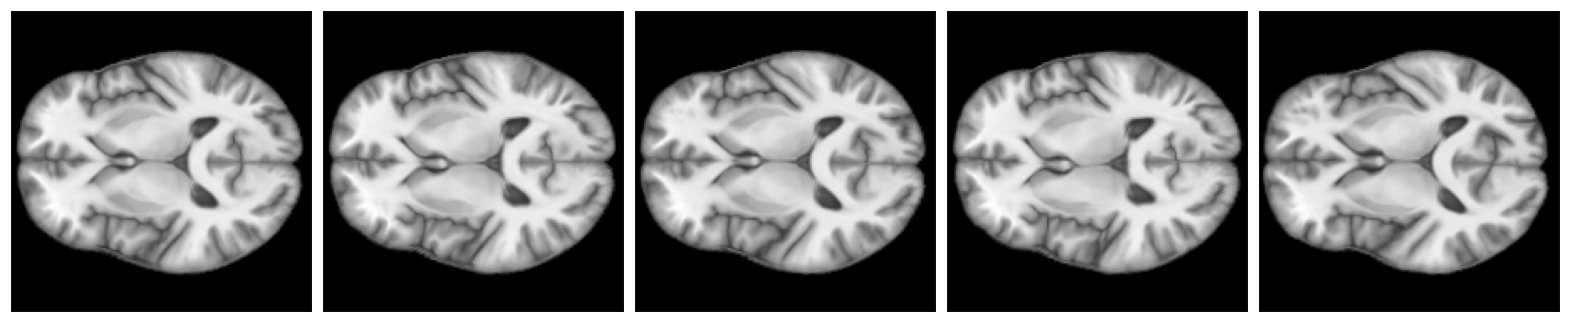

In [22]:
import utils.visualize as vis

plt.rcParams["figure.figsize"] = 20,5

diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in diff], clim=(-1,1), cols=5, cmap='seismic')
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in rr], clim=(0,1), cols=5)

In [23]:
# sex = np.concatenate([d[0].numpy() for d in test_loader],axis=0)
# age = np.concatenate([d[1].numpy() for d in test_loader],axis=0)
# bmi = np.concatenate([d[2].numpy() for d in test_loader],axis=0)

In [24]:
disease = np.concatenate([d[0].numpy() for d in test_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in test_loader],axis=0)

In [25]:


# age = np.round(age)
# age-=min_age

encoded_data = kpca.transform(test_imgs)

In [26]:
with open(test_path, 'wb') as f:
    pickle.dump({'imgs':test_imgs, 'disease':disease,'bias':bias, 'kpca':kpca,'encoded_data':encoded_data}, f)